In [1]:
# import sys
# !{sys.executable} -m pip install missingno

import os
import pandas as pd
pd.options.mode.chained_assignment = None
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import numpy as np
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [2]:
os.getcwd()

'C:\\Users\\Diego\\Desktop\\Competitions_datacamp'

In [3]:
##### Define useful functions to use in the analysis

In [4]:
# Change data types to categorical for those with not many unique values
def convert_to_categorical(df, tolerance):
    """
    Function to convert cdf columns to categorical depending on their row number compared with the 
    total length of the dataframe. Yes no variables are converted to 1 and 0
    :param df, tolerance: Tolerance in x.xx format
    :return: Dataframe with converted columns
    """
    for column in df.columns:
        if ((df[column].nunique() < (tolerance * df_subset.shape[0])) and (df[column].nunique() >2)):
            df[column] = df[column].astype('category')
        elif ((df[column].nunique() < (tolerance * df_subset.shape[0])) and (df[column].nunique() == 2)):
            df[column] = df[column].astype('category')
            if "Yes" in df[column].unique():
                df[column] = df[column].map({'Yes': 1, 'No': 0})

# Get summary dataframe
def unique_values(df):
    """
    Get distinct values and number of them in a dataframe
    :param df: Dataframe to check
    :return: Df with list and count of unique values
    """
    values = df.apply(lambda col: col.unique())
    counts = df.apply(lambda col: col.nunique())
    resumen = pd.concat([values, counts], axis=1)
    return (resumen)

def categorical_variables_plots(df, cols_to_skip):
    """
    Create barplots for categorical  variables
    :param df: Dataframe with variables to plot
    :param cols_to_skip: list of columns that shouldnt be plotted
    :return: Nothing. Plots 
    """
    ix = 1
    fig = plt.figure(figsize = (15,10))
    for c in list(df.columns):
        if ix <= 3:
            if c not in cols_to_skip:
                ax1 = fig.add_subplot(2,3,ix)
                sns.countplot(data = df, x=c, ax = ax1)
                #ax2 = fig.add_subplot(2,3,ix+3)
                #sns.boxplot(data=ds_cat, x=c, y='SalePrice', ax=ax2)
                #sns.violinplot(data=ds_cat, x=c, y='SalePrice', ax=ax2)
                #sns.swarmplot(data = ds_cat, x=c, y ='SalePrice', color = 'k', alpha = 0.4, ax=ax2)

        ix = ix +1
        if ix == 4: 
            fig = plt.figure(figsize = (15,10))
            ix =1

In [5]:
# Read trees dataframe and neighborhood from data using geopandas for the second
df = pd.read_pickle("data/dummy.pkl")
neighborhoods = gpd.read_file('data/neigh.shp')

In [6]:
df.head()
neighborhoods.head()

,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng,geometry
0,3.0,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,"POLYGON ((-73.94733 40.62917, -73.94687 40.626..."
1,3.0,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,"POLYGON ((-73.94193 40.70073, -73.94439 40.700..."
2,2.0,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,"POLYGON ((-73.89138 40.86170, -73.89106 40.861..."
3,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,"POLYGON ((-73.97605 40.63128, -73.97717 40.630..."
4,3.0,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,"POLYGON ((-73.90856 40.65210, -73.90945 40.651..."


In [7]:
df_subset = df[["tree_id",	"tree_dbh",	"curb_loc",	"spc_common","status","health","root_stone","root_grate","root_other","trunk_wire","trnk_light","trnk_other","brch_light","brch_shoe","brch_other","nta","nta_name","latitude",	"longitude"]]

In [8]:
df_subset.head()

,tree_id,tree_dbh,curb_loc,spc_common,status,health,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,nta,nta_name,latitude,longitude
0,180683,3,OnCurb,red maple,Alive,Fair,No,No,No,No,No,No,No,No,No,QN17,Forest Hills,40.72309177,-73.84421522
1,200540,21,OnCurb,pin oak,Alive,Fair,Yes,No,No,No,No,No,No,No,No,QN49,Whitestone,40.79411067,-73.81867946
2,204026,3,OnCurb,honeylocust,Alive,Good,No,No,No,No,No,No,No,No,No,BK90,East Williamsburg,40.71758074,-73.9366077
3,204337,10,OnCurb,honeylocust,Alive,Good,Yes,No,No,No,No,No,No,No,No,BK90,East Williamsburg,40.71353749,-73.93445616
4,189565,21,OnCurb,American linden,Alive,Good,Yes,No,No,No,No,No,No,No,No,BK37,Park Slope-Gowanus,40.66677776,-73.97597938


In [9]:
# Get info from dataset like number of nulls and data types
print(df_subset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 19 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   tree_id     683788 non-null  object
 1   tree_dbh    683788 non-null  object
 2   curb_loc    683788 non-null  object
 3   spc_common  652169 non-null  object
 4   status      683788 non-null  object
 5   health      652172 non-null  object
 6   root_stone  683788 non-null  object
 7   root_grate  683788 non-null  object
 8   root_other  683788 non-null  object
 9   trunk_wire  683788 non-null  object
 10  trnk_light  683788 non-null  object
 11  trnk_other  683788 non-null  object
 12  brch_light  683788 non-null  object
 13  brch_shoe   683788 non-null  object
 14  brch_other  683788 non-null  object
 15  nta         683788 non-null  object
 16  nta_name    683788 non-null  object
 17  latitude    683788 non-null  object
 18  longitude   683788 non-null  object
dtypes: object(19)
memory us

In [10]:
# Check for duplicated rows
df_subset.duplicated().sum()

0

In [11]:
# Print unique values for columns
resumen = unique_values(df_subset)
resumen

,0,1
tree_id,"[180683, 200540, 204026, 204337, 189565, 19042...",683788
tree_dbh,"[3, 21, 10, 11, 9, 6, 8, 13, 22, 30, 12, 2, 14...",146
curb_loc,"[OnCurb, OffsetFromCurb]",2
spc_common,"[red maple, pin oak, honeylocust, American lin...",132
status,"[Alive, Stump, Dead]",3
health,"[Fair, Good, Poor, nan]",3
root_stone,"[No, Yes]",2
root_grate,"[No, Yes]",2
root_other,"[No, Yes]",2
trunk_wire,"[No, Yes]",2


In [148]:
# Check number of nas 
df_subset.isna().sum()

tree_id           0
tree_dbh          0
curb_loc          0
spc_common    31619
status            0
health            0
root_stone        0
root_grate        0
root_other        0
trunk_wire        0
trnk_light        0
trnk_other        0
brch_light        0
brch_shoe         0
brch_other        0
nta               0
nta_name          0
latitude          0
longitude         0
geometry          0
dtype: int64

<AxesSubplot:>

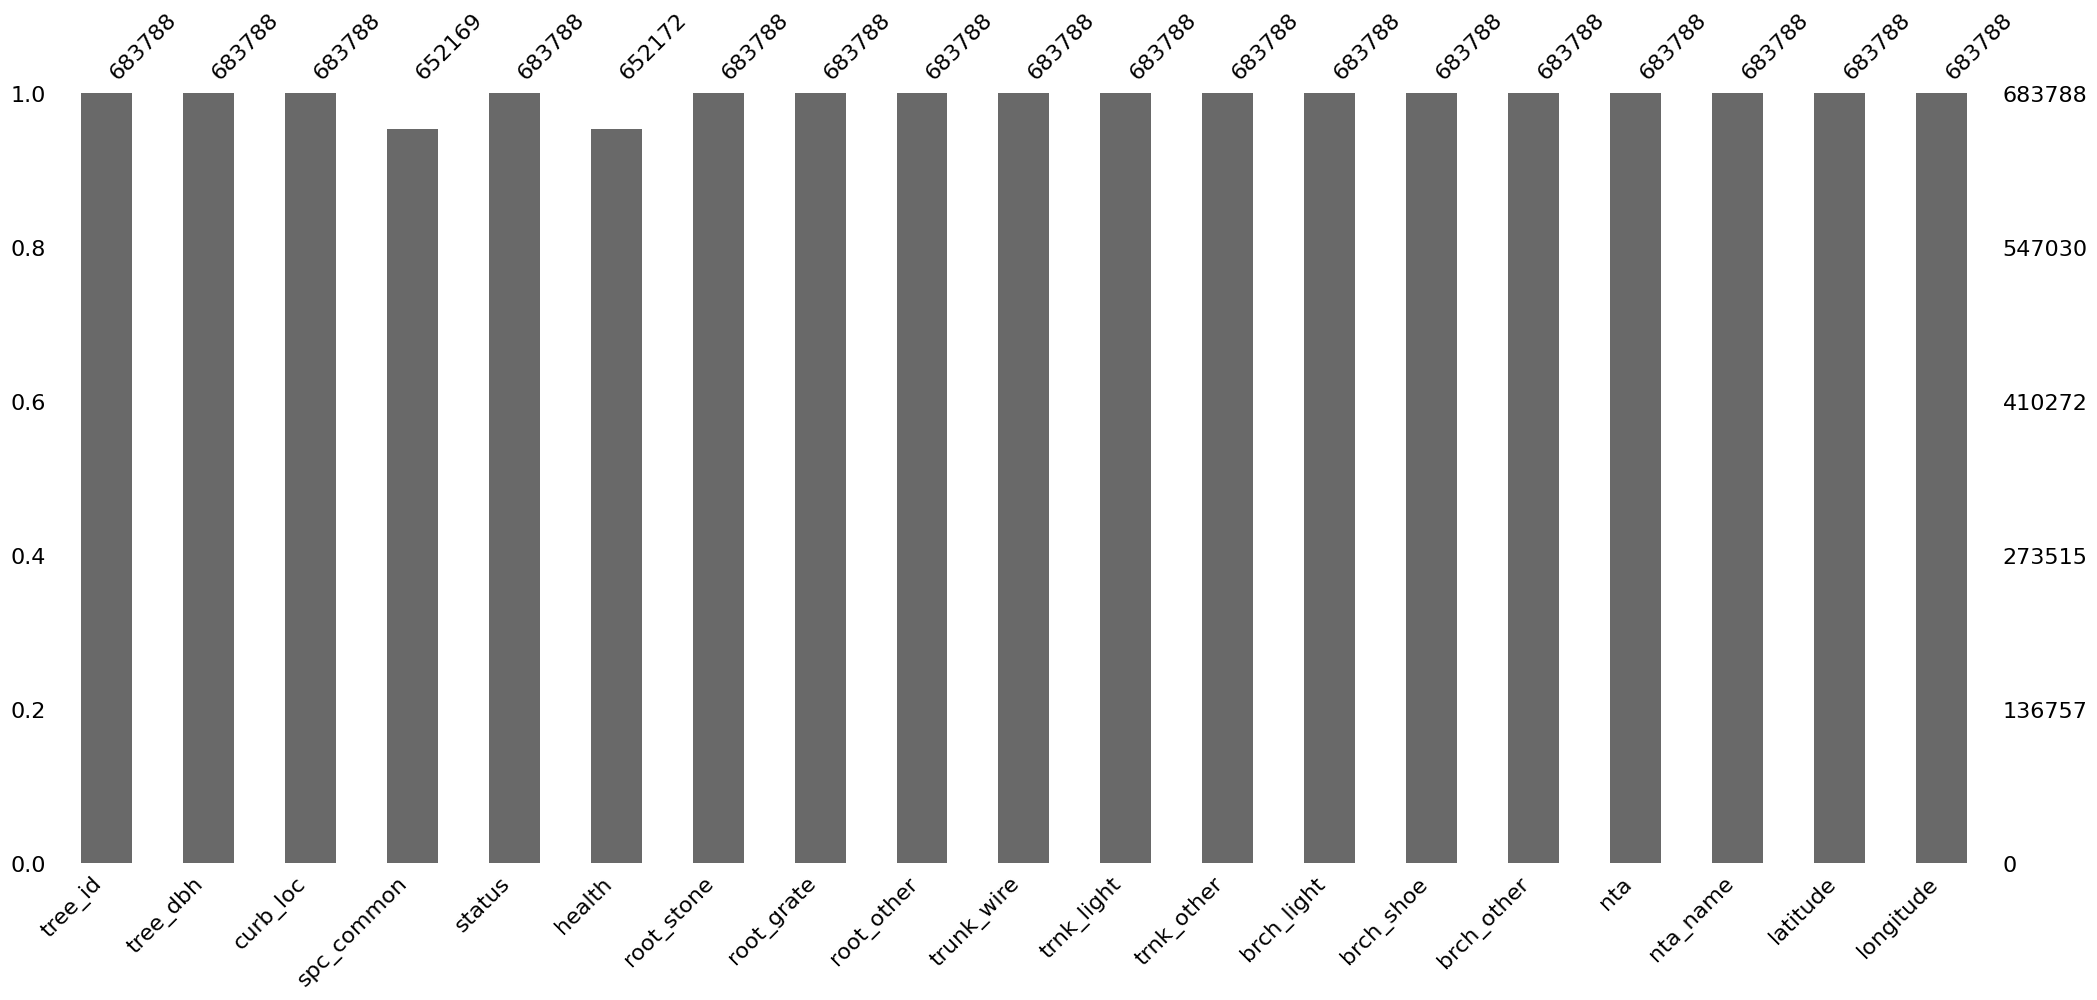

In [14]:
# Lets explore the NA. first with barchart
msno.bar(df_subset)

<AxesSubplot:>

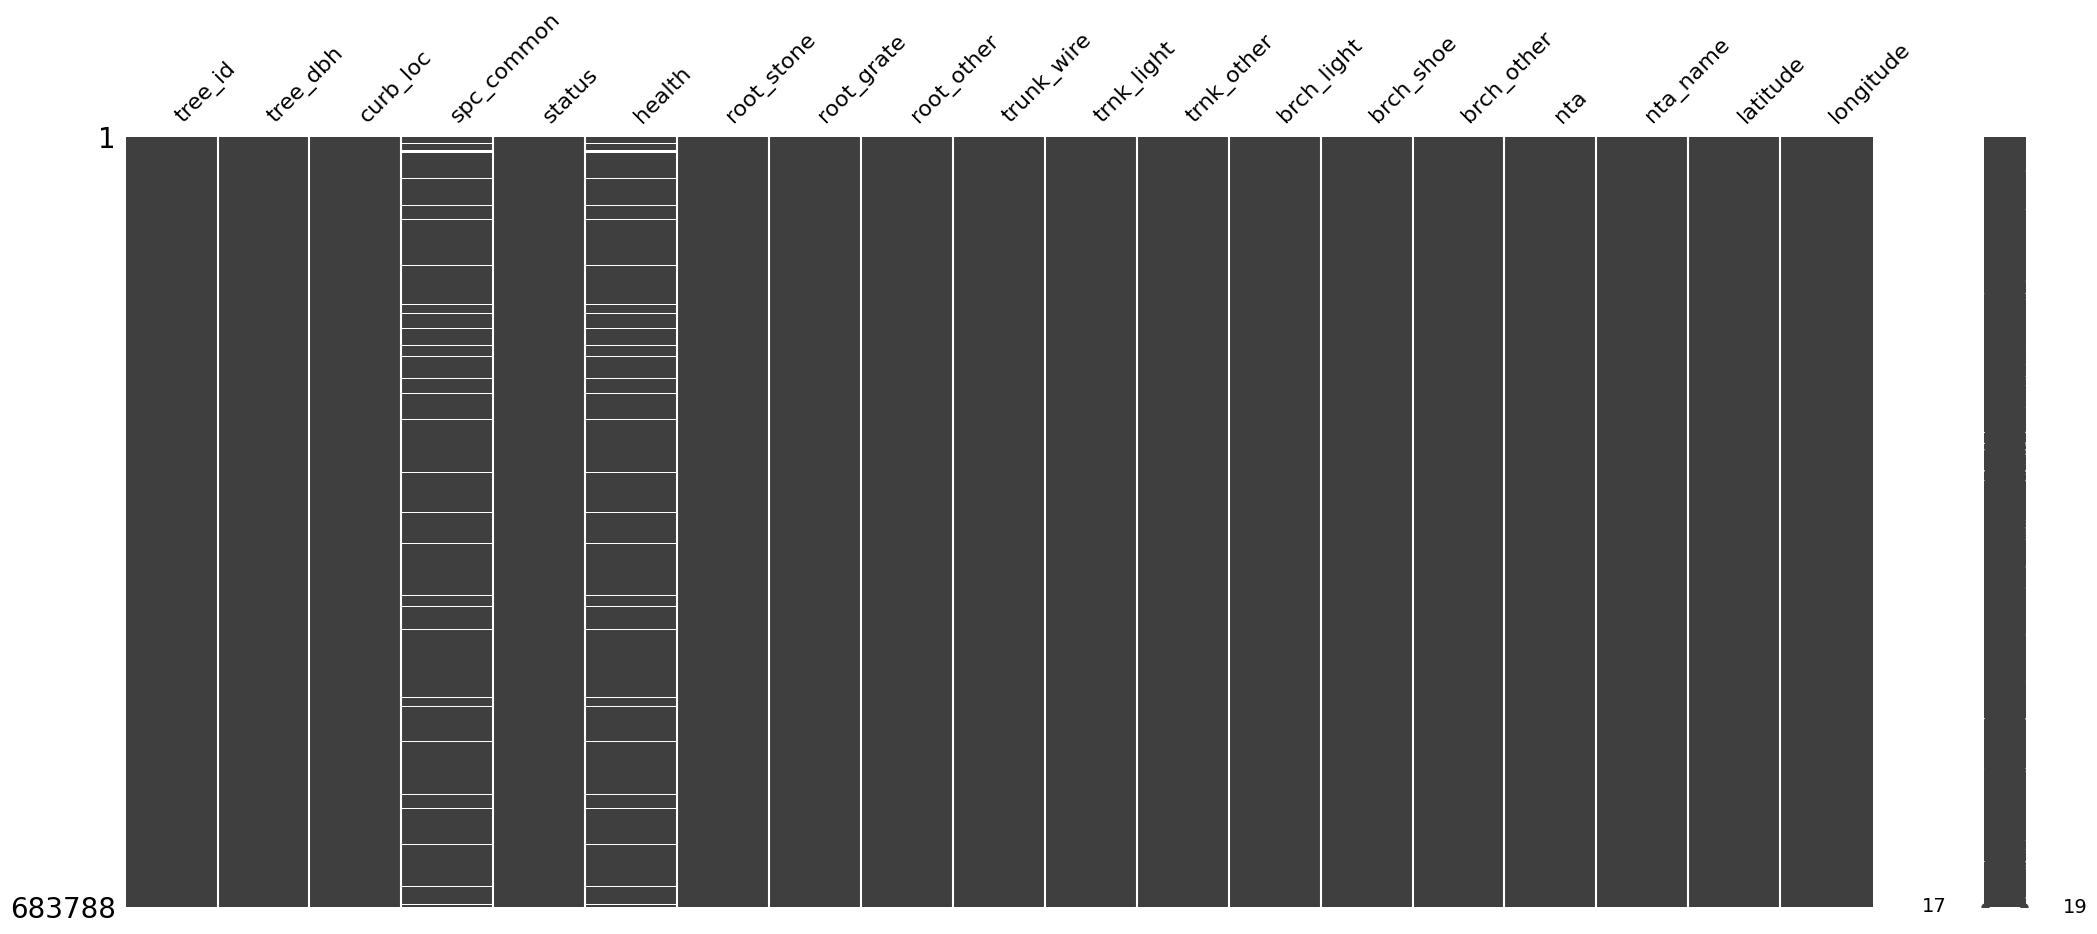

In [15]:
# Gives positional information of the missing values
msno.matrix(df_subset)

<AxesSubplot:>

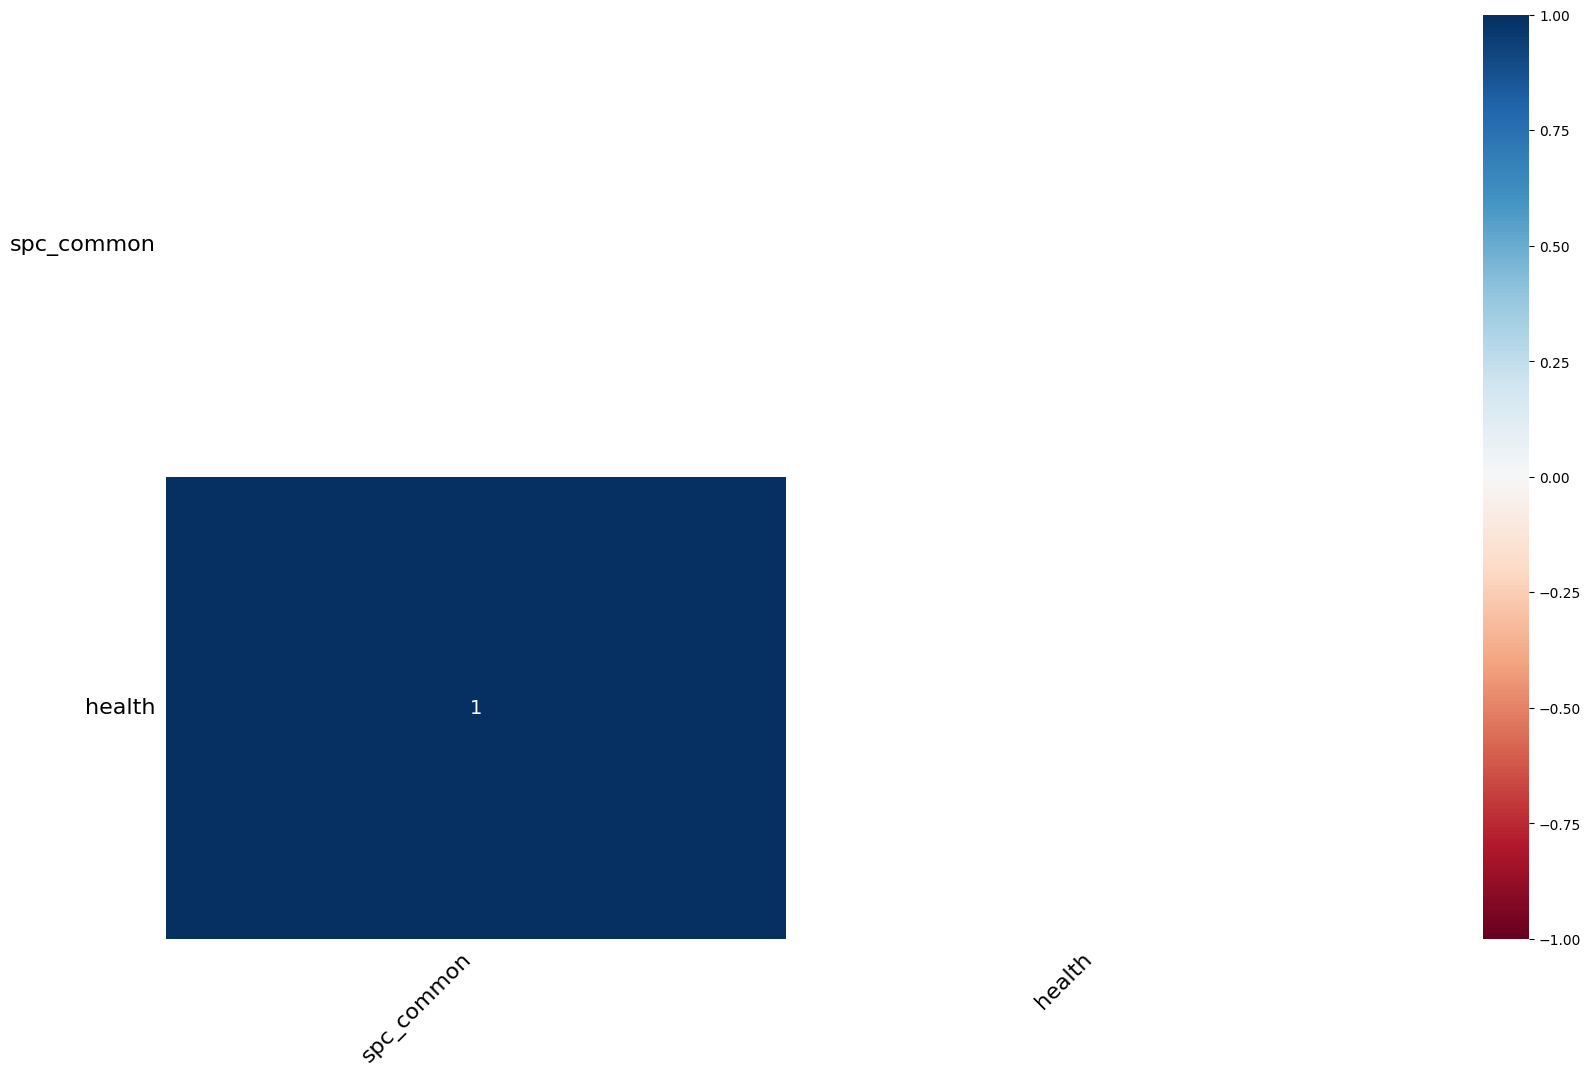

In [16]:
# Gives a heatmap of how missing values are related
# Only represents variables with missing values and a correlation of 1 means that each missing value from one variable
#corresponds a missing value from the other variable
msno.heatmap(df_subset)

In [17]:
## Deal with missing data ##
# The proportion of NAs here is less than 50%. In other case we have to get rid of them

# lets check which rows have NA in the 2 variables
# Lets check if there is something relevant about this df
df_nan = df_subset[df_subset.isna().any(axis=1)]

In [18]:
# It seems that all trees considered as Dead or Stump are the ones without spc or health
df_nan.head()

,tree_id,tree_dbh,curb_loc,spc_common,status,health,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,nta,nta_name,latitude,longitude
37,211205,0,OnCurb,NaN,Stump,NaN,No,No,No,No,No,No,No,No,No,QN72,Steinway,40.77499266,-73.92203675
57,187807,0,OnCurb,NaN,Dead,NaN,No,No,No,No,No,No,No,No,No,BX43,Norwood,40.87192665,-73.88234856
196,208322,10,OnCurb,NaN,Dead,NaN,No,No,No,No,No,No,No,No,No,BK77,Bushwick North,40.70574154,-73.91784901
209,209058,6,OnCurb,NaN,Dead,NaN,No,No,No,No,No,No,No,No,No,SI25,Oakwood-Oakwood Beach,40.55906117,-74.10603753
239,203597,0,OnCurb,NaN,Stump,NaN,No,No,No,No,No,No,No,No,No,QN72,Steinway,40.77248279,-73.90907286


In [19]:
print(df_subset["health"].unique())
print(df_subset["status"].unique())

['Fair' 'Good' 'Poor' nan]
['Alive' 'Stump' 'Dead']


In [20]:
# Checking for variable status 
df_nan["status"].value_counts()

Stump    17654
Dead     13961
Alive        6
Name: status, dtype: int64

[Text(0.5, 0, 'Total'),
 Text(0, 0.5, 'Status'),
 Text(0.5, 1.0, 'Count of status and Curb position')]

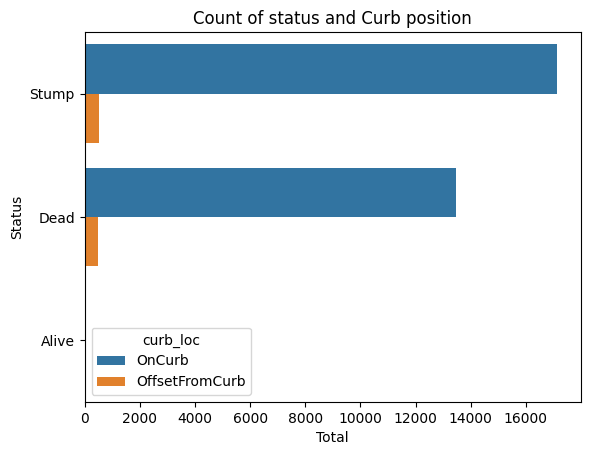

In [21]:
# Representation of countplot with different features
bar_count = sns.countplot(data=df_nan,
              y="status",
              hue="curb_loc",
              orient="v")

bar_count.set(xlabel ="Total", ylabel = "Status", title ='Count of status and Curb position')

## NAs treatment

In [22]:
# As the number of NAs is 5% and it relies on categorical variables, we will create a 
# new status health as Death and new species as Dead. We will do it before refactoring

In [23]:
df_subset['health'] = df_subset['health'].fillna("Dead")
df_subset['curb_loc'] = df_subset['curb_loc'].fillna("Dead")

In [24]:
# Apply function to dataframe
convert_to_categorical(df_subset,0.05)

### Nas imputation

In [25]:
df_imputed = df[["tree_id",	"tree_dbh",	"curb_loc",	"spc_common","status","health","root_stone","root_grate","root_other","trunk_wire","trnk_light","trnk_other","brch_light","brch_shoe","brch_other","nta","nta_name","latitude",	"longitude"]]

In [26]:
from sklearn.impute import SimpleImputer

In [27]:
# Mode Imputation
#df_mode = df_imputed.copy()
#mode_imputer = SimpleImputer(strategy='most_frequent')
#df_mode['health'] = mode_imputer.fit_transform(df_mode['health'].values.reshape(-1,1))

In [28]:
# Mode imputation plot
#fig = plt.Figure()
#null_values = df_imputed['health'].isnull()
#fig = df_mode.plot(x='numeric_variable', y='numeric_variable', kind='scatter', c=null_values, cmap='winter', title='Mode Imputation', colorbar=False)

In [29]:
# Mean Imputation
#df_mean = df.copy()
#mean_imputer = SimpleImputer(strategy='mean')
#df_mean['MaxSpeed'] = mean_imputer.fit_transform(df_mean['MaxSpeed'].values.reshape(-1,1))

# Time series imputation
# Ffill imputation
ffill_imputation = df.fillna(method='ffill')

# Plot imputed data
ffill_imp['MaxSpeed'][:100].plot(color='red', marker='o', linestyle='dotted')
df['MaxSpeed'][:100].plot(title='MaxSpeed', marker='o')

# Imputing with linear interpolation
linear_interpolation = df.interpolate(method='linear')

# Plot imputed data
linear_int['MaxSpeed'][:100].plot(color='red', marker='o', linestyle='dotted')
df['MaxSpeed'][:100].plot(title='MaxSpeed', marker='o')

# Imputing with KNNImputer

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

#Define a subset of the dataset
df_knn = df.filter(['Distance','MaxSpeed','AvgSpeed','AvgMovingSpeed'], axis=1).copy()

# Define scaler to set values between 0 and 1

scaler = MinMaxScaler(feature_range=(0, 1))
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)

# Define KNN imputer and fill missing values
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)

### Exploratory data analysis

In this dataset, there are not numerical variables, so we have to develop a categorical analysis 

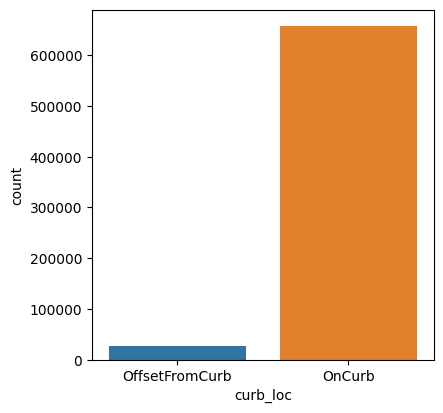

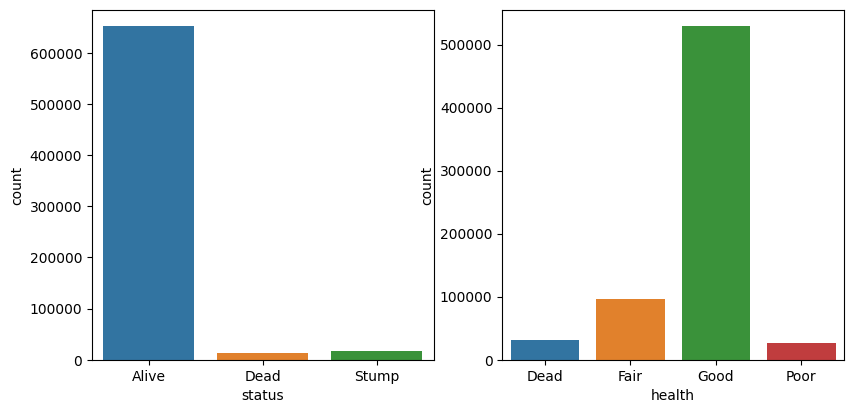

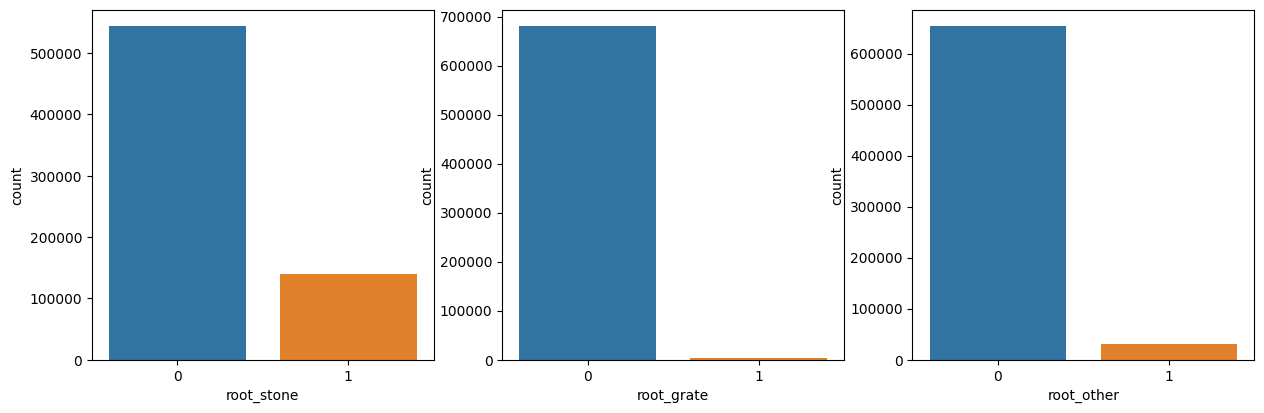

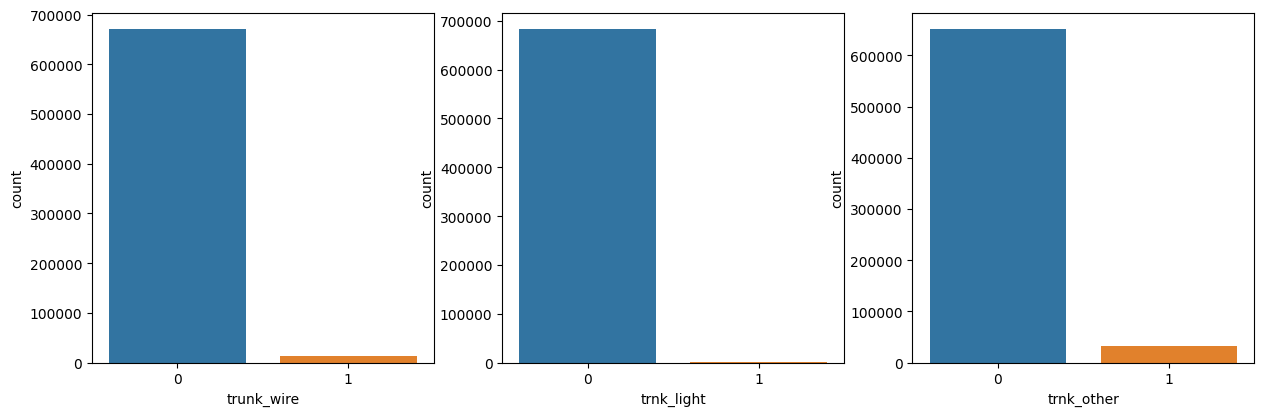

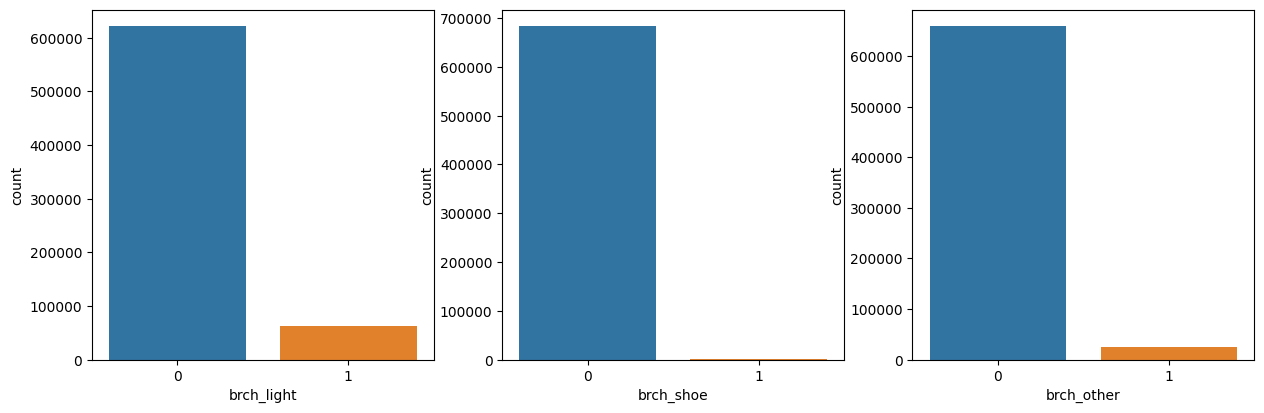

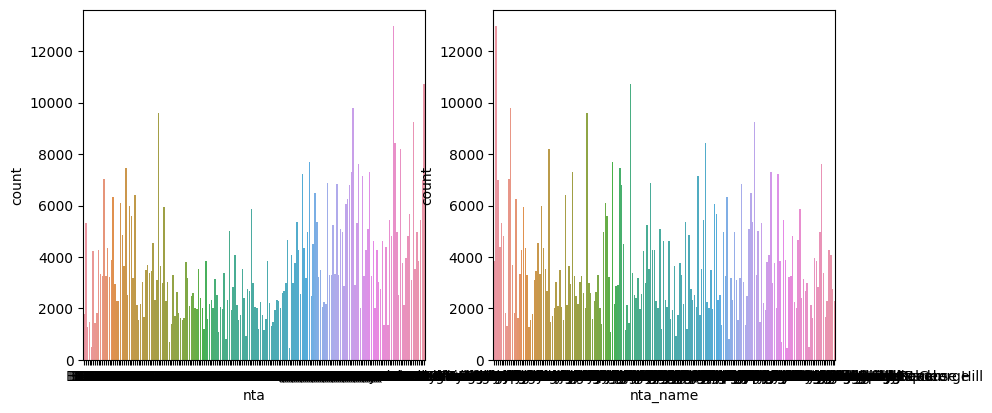

<Figure size 1500x1000 with 0 Axes>

In [30]:
# First, we can create plots showing the number of ocurrences for each categorical variable.
categorical_variables_plots(df_subset, ["tree_dbh", "tree_id", "latitude", "longitude", "spc_common"])

Most of the trees are located on the curb, usually with good or fair health and almost none of them have problems with their roots or branches. The most common issue is to have a root stone.

Before we continue, its good to check position on the map.
With shp files, there is a pack of files which we need to keep togeteher. One contains the shape of the map of a place we are analyzing. We have to read and convert the dataframe with data into a geopandas dataframe by joining latitude and longitude into points

<AxesSubplot:>

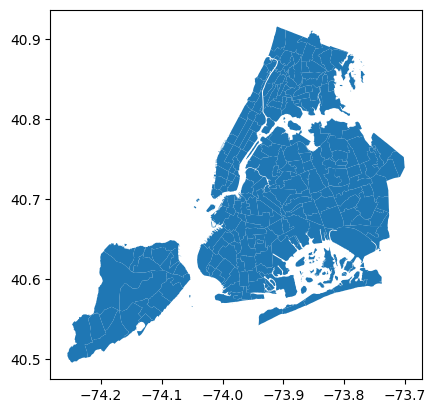

In [31]:
# We can combine 2 datasets to see the location of the trees on a map
neighborhoods.to_crs(epsg=4326).plot()

In [32]:
# Convert to geopandas dataframe always that we have longitude and latitude in the dataset
gdf = gpd.GeoDataFrame(
    df_subset, geometry=gpd.points_from_xy(df_subset["longitude"], df_subset["latitude"]))

Text(0.5, 1.0, 'Location of the trees')

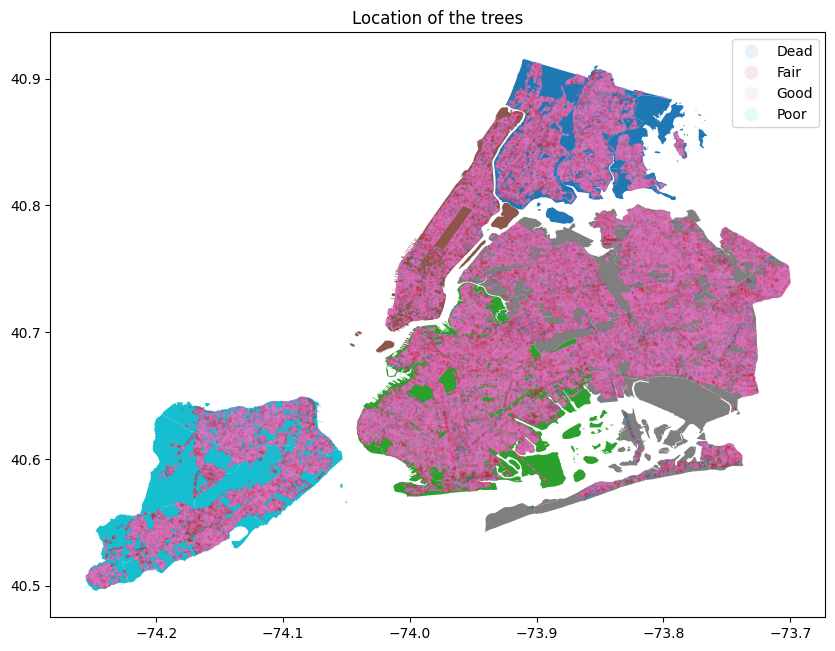

In [33]:
# The first line is to plot everything on the same plot or fig
fig, ax = plt.subplots(figsize = (10,10))

# Then we plot the base map, the data with coordinates that comes from the .shp file
neighborhoods.to_crs(epsg=4326).plot(
    ax=ax, # Specify axes to set
    column="boroname", # Specify categorical column to color regions 
    legend=True,
    figsize=(10, 10),
    missing_kwds={ # These are params for missing values
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
);

# Then we plot the dataframe containing the points. There are a lot of points so we set alpha and markersize
gdf.plot(ax=ax, alpha = .1, markersize = 0.5, column = "health",legend=True)

#Set titles
ax.set_title('Location of the trees')

### Pivot tables

Before continuing with the work, lets combine tables to identify boroname in trees dataset

In [34]:
gdf_merged = gdf.merge(neighborhoods[["ntacode","boroname"]], left_on = "nta", right_on="ntacode")

In [35]:
gdf_merged.drop(['ntacode'], axis=1, inplace=True)

In [36]:
# Create pivot table for number of trees by boroname
resumen = gdf_merged.pivot_table("tree_id",
                                 index = "boroname",
                                 columns = "health",
                                 aggfunc="count")

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Bronx'),
  Text(1, 0, 'Brooklyn'),
  Text(2, 0, 'Manhattan'),
  Text(3, 0, 'Queens'),
  Text(4, 0, 'Staten Island')])

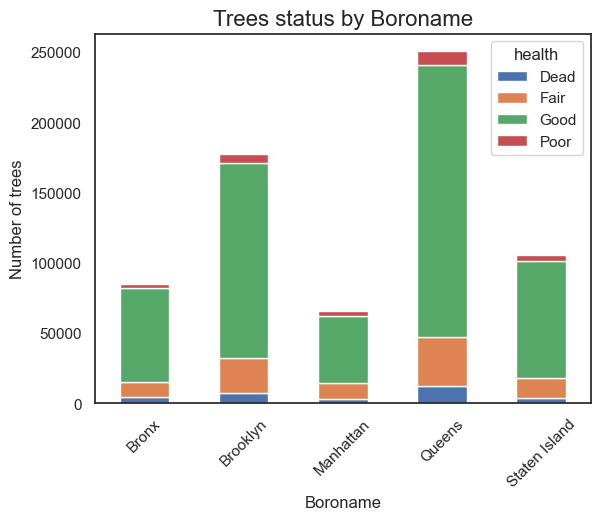

In [37]:
#set seaborn plotting aesthetics
sns.set(style='white')

#create stacked bar chart
resumen.plot(kind='bar', stacked=True)

#add overall title
plt.title('Trees status by Boroname', fontsize=16)

#add axis titles
plt.xlabel('Boroname')
plt.ylabel('Number of trees')

#rotate x-axis labels
plt.xticks(rotation=45)

## What are the most common tree species in Manhattan?

In [38]:
# Lets filter by mahattan
gdf_manhattan = gdf_merged.query("boroname == 'Manhattan'")

In [39]:
gdf_manhattan.spc_common.value_counts()

honeylocust       13203
Callery pear       7344
ginkgo             5867
pin oak            4604
Sophora            4461
                  ...  
pignut hickory        1
trident maple         0
Shantung maple        0
false cypress         0
Atlas cedar           0
Name: spc_common, Length: 132, dtype: int64

In [40]:
# generate pivot table based con spc_common
sp_man = gdf_manhattan.pivot_table(values="tree_id",
                                 index = "spc_common",
                                 aggfunc={'tree_id': "count"})

In [41]:
# Sort values, and get 10 most common trees
sp_man = sp_man.sort_values(by="tree_id", ascending=False).reset_index().iloc[:11]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'honeylocust'),
  Text(1, 0, 'Callery pear'),
  Text(2, 0, 'ginkgo'),
  Text(3, 0, 'pin oak'),
  Text(4, 0, 'Sophora'),
  Text(5, 0, 'London planetree'),
  Text(6, 0, 'Japanese zelkova'),
  Text(7, 0, 'littleleaf linden'),
  Text(8, 0, 'American elm'),
  Text(9, 0, 'American linden'),
  Text(10, 0, 'northern red oak')])

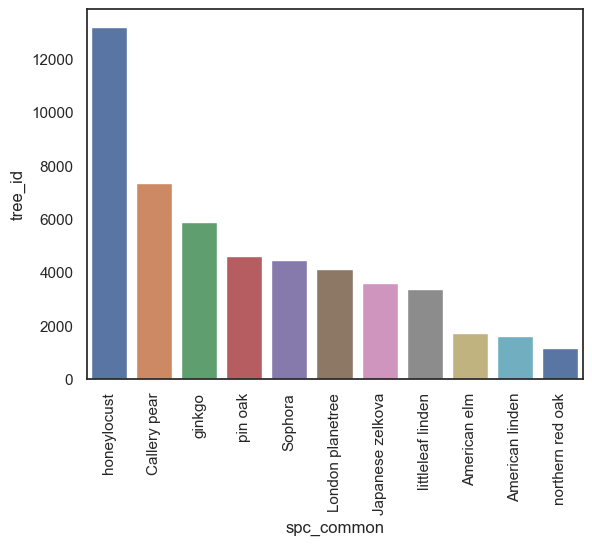

In [42]:
# Create barplot using the previous dataframe
sns.barplot(data = sp_man,
            x="spc_common",
            y="tree_id",
            order = sp_man.
                    sort_values('tree_id', ascending=False).spc_common,
           palette="deep")
plt.xticks(rotation=90)

The most common tree located in Manhattan is the honeylocust with 13203 trees

## Which are the neighborhoods with the most trees?

We can find  this solution creating a pivot table with the count of trees by meighborhood

In [43]:
n_trees = gdf_merged.pivot_table(values="tree_id",
                                 index = "nta_name",
                                 aggfunc={'tree_id': "count"})

In [44]:
# Sort values, and get 10 neighborhoods with more trees
n_trees = n_trees.sort_values(by="tree_id", ascending=False).reset_index().iloc[:11]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, "Annadale-Huguenot-Prince's Bay-Eltingville"),
  Text(1, 0, 'Great Kills'),
  Text(2, 0, 'Bayside-Bayside Hills'),
  Text(3, 0, 'East New York'),
  Text(4, 0, 'Rossville-Woodrow'),
  Text(5, 0, 'New Springville-Bloomfield-Travis'),
  Text(6, 0, 'Charleston-Richmond Valley-Tottenville'),
  Text(7, 0, 'Forest Hills'),
  Text(8, 0, 'Whitestone'),
  Text(9, 0, 'Georgetown-Marine Park-Bergen Beach-Mill Basin'),
  Text(10, 0, 'South Ozone Park')])

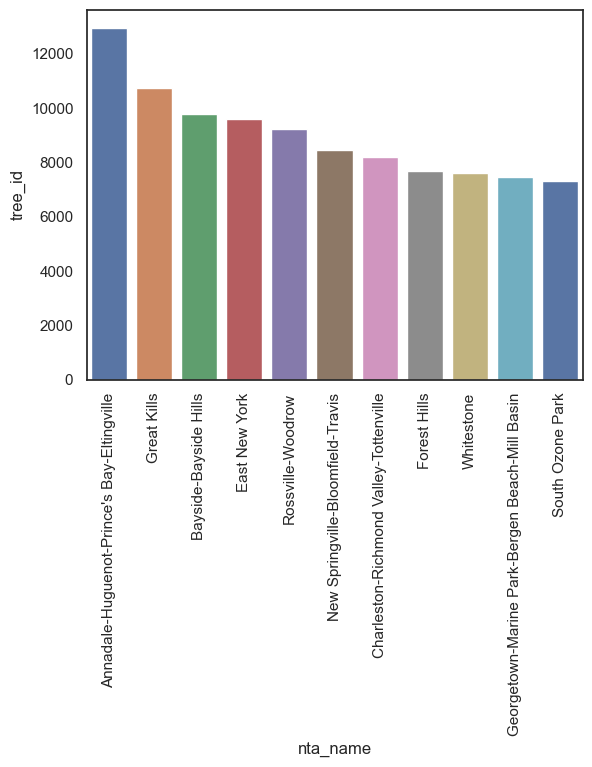

In [45]:
# Create barplot using the previous dataframe
sns.barplot(data = n_trees,
            x="nta_name",
            y="tree_id",
            order = n_trees.
                    sort_values('tree_id', ascending=False).nta_name,
           palette="deep")
plt.xticks(rotation=90)

The neighborhood with biggest number of trees is Annadale-Huguenot-Prince's Bay-Eltingville, with 12969 trees of all species

## A visualization of Manhattan's neighborhoods and tree locations

In [46]:
# First, we filter the dataframe so we get only rows whose boroname is Manhattan
man = neighborhoods.loc[neighborhoods["boroname"]=="Manhattan"]

In [109]:
# We also filter the dataset with the trees
man_gdf = gdf_merged.loc[gdf_merged["boroname"] == "Manhattan"]

Text(0.5, 1.0, 'Location of the trees in Manhattan based on health')

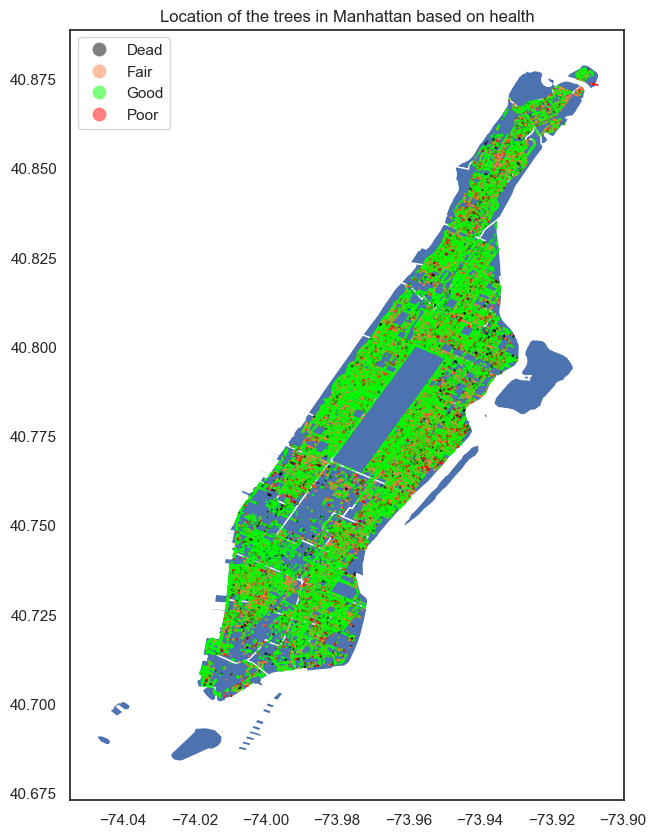

In [48]:
import matplotlib.colors as colors

# The first line is to plot everything on the same plot or fig
fig, ax = plt.subplots(figsize = (10,10))

# Then we plot the base map, the data with coordinates that comes from the .shp file filtered by Manhattan
man.to_crs(epsg=4326).plot(
    ax=ax, # Specify axes to set 
    figsize=(10, 10),
);

# Then we plot the dataframe containing the points. There are a lot of points so we set alpha and markersize.
# We pass a user defined list of colors
man_gdf.plot(ax=ax, alpha = .5, markersize = 0.5, column = "health", legend = True, cmap=colors.ListedColormap(['#000000','#FF7D40','#00FF00','#FF0000']))

#Set titles
ax.set_title('Location of the trees in Manhattan based on health')

## What ten tree species would you recommend the city plant in the future?

To get this answer, i come up with the idea of using logistic regression. We can use the species and the rest of binary variables of the dataset to predict if a new plant is going to be alive and in good conditions. Once we get the model, the species which is more positive (contributes more to outcome 1) will be the best to plant.

In [110]:
# Firstly, we check the species proportion
man_gdf["spc_common"].value_counts(normalize=True)

honeylocust       0.210692
Callery pear      0.117195
ginkgo            0.093625
pin oak           0.073470
Sophora           0.071188
                    ...   
pignut hickory    0.000016
trident maple     0.000000
Shantung maple    0.000000
false cypress     0.000000
Atlas cedar       0.000000
Name: spc_common, Length: 132, dtype: float64

There are too many categories for species, so we will keep the 10 species with more trees and catalogue the rest as "Other"

In [111]:
man_gdf["spc_common"] = np.where(man_gdf["spc_common"].isin(["honeylocust","Callery pear","ginkgo",
                                                               "pin oak","Sophora","London planetree","Japanese zelkova",
                                                               "littleleaf linden","American elm","American linden",
                                                               "northern red oak"]), man_gdf["spc_common"], "Other")

In [113]:
# Now proportions are much more similar between species
man_gdf["spc_common"].value_counts(normalize=True)

Other                0.223104
honeylocust          0.201054
Callery pear         0.111834
ginkgo               0.089342
pin oak              0.070109
Sophora              0.067932
London planetree     0.062785
Japanese zelkova     0.055034
littleleaf linden    0.051059
American elm         0.026009
American linden      0.024304
northern red oak     0.017436
Name: spc_common, dtype: float64

In [114]:
# Creation of dummy variables with spc_common
dummies = pd.get_dummies(man_gdf["spc_common"], drop_first = True)
man_gdf_2 = man_gdf.copy()

# Remove dummy variable
man_gdf_2.drop(["spc_common"], axis=1, inplace=True)

# Join both dataframes
man_dummy = pd.concat([man_gdf_2, dummies], axis = 1)

# Create a target variable combining 2 requirements: Plants shpuld be alive and its health should be good
man_dummy["target"] = np.where((man_dummy["status"] == "Alive") & (man_dummy["health"] == "Good"), 1,0)

In [115]:
df_final = man_dummy.drop(["tree_dbh","tree_id","curb_loc","status","health","nta","nta_name","latitude","longitude","geometry","boroname"], axis=1)

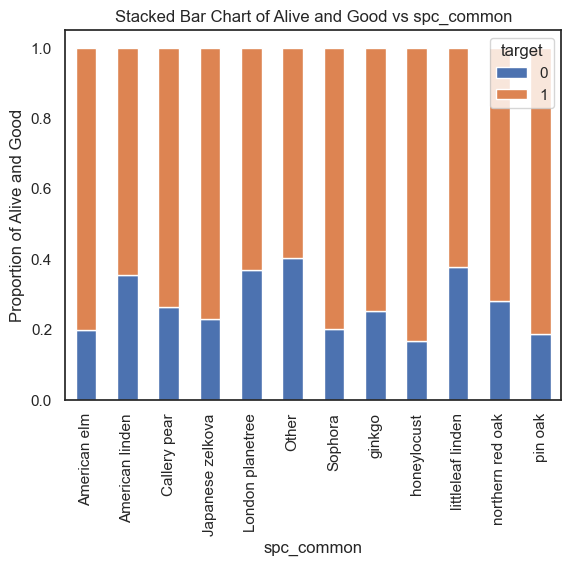

In [120]:
# We can use a barplot to check if the categorical variables are relevant to include in the model
table=pd.crosstab(man_gdf.spc_common,df_final.target)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Alive and Good vs spc_common')
plt.xlabel('spc_common')
plt.ylabel('Proportion of Alive and Good')
plt.show()

Of course the trees are very relevant, and the rest of variables not so much but we will include them anyways due to the lack of other measures like pollution, humidity, wind, etc. And we are focusing on Manhattan so we can eliminate the neighborhood too.

In [127]:
# Lets divide the dataset into train and test data
X = df_final.loc[:, df_final.columns != 'target']
y = df_final.loc[:, df_final.columns == 'target']

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

In [128]:
# It will be necessary to oversample the 0 outcome of the target variable because its proportion is
# smaller than the other
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['target'])

In [136]:
# Perform recursive feature elimination to get relevant variables
data_final_vars=df_final.columns.values.tolist()
y=['target']
X=[i for i in data_final_vars if i not in y]

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
rfe = RFE(logreg, n_features_to_select=10, step=1)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())

print(rfe.support_)
print(rfe.ranking_)

[False  True False False  True  True  True False  True  True False False
  True  True False False  True  True False False]
[ 7  1  9 11  1  1  1  2  1  1  5  6  1  1 10  4  1  1  3  8]


In [137]:
# After this result, we choose the columns corresponding to the chosen values
cols =['root_grate','trnk_light','trnk_other', 'brch_light', 'brch_other', 'American linden',
       'London planetree', 'Other','honeylocust','littleleaf linden']
X=os_data_X[cols]
y=os_data_y['target']

Index(['root_stone', 'root_grate', 'root_other', 'trunk_wire', 'trnk_light',
       'trnk_other', 'brch_light', 'brch_shoe', 'brch_other',
       'American linden', 'Callery pear', 'Japanese zelkova',
       'London planetree', 'Other', 'Sophora', 'ginkgo', 'honeylocust',
       'littleleaf linden', 'northern red oak', 'pin oak', 'target'],
      dtype='object')

After the model preparation, we can implement it

In [141]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.660632
         Iterations 5
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.047     
Dependent Variable:  target           AIC:              88132.4207
Date:                2022-12-29 02:19 BIC:              88223.4985
No. Observations:    66688            Log-Likelihood:   -44056.   
Df Model:            9                LL-Null:          -46225.   
Df Residuals:        66678            LLR p-value:      0.0000    
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      5.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
root_grate        -0.1892   0.0414  -4.5682 0.0000 -0.2703 -0.1080
trnk_light         0.5708   0.1331   4.2878 0.0000  0

The p_value for all of the variables is 0, which means that all of them are significant. Checking the coefficients, honeylocust contributes the most to the model (not surprisingbecause is the dominant tree in this area) so we can conclude that if the government decides to plant more trees, with this species they have many chances to be correct.

We proceed to the model fitting and the calculation of the accuracy to finish the logistic regression prediction.

In [145]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.63


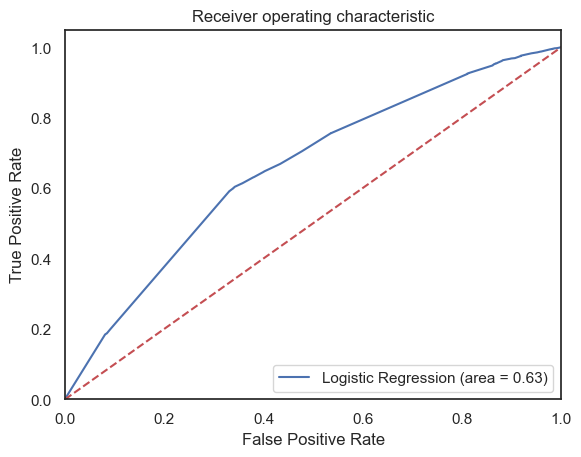

In [146]:
# Finally we can plot the ROC curve which is not one of the furthest from a linear estimator but gives us an accuracy of 0.63
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()